!pip install PySastrawi
!pip install gensim
!pip install pyLDAvis==2.1.2

In [2]:
import re
import string
from requests_html import HTMLSession
import requests
import json
import spacy
from langdetect import detect
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacy_langdetect import LanguageDetector
from textblob import TextBlob

In [38]:
import pyLDAvis.gensim_models
import random
import time
import string
import nltk
import nest_asyncio
import itertools
import gensim
import urllib.request
import pyLDAvis
#import pyLDAvis.gensim

from textblob import TextBlob as tb
from collections import Counter
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
#from wordcloud import WordCloud
from itertools import chain

nest_asyncio.apply()
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

# Web Scraping

## Tiket.com

In [4]:
tiket = ['https://en.tiket.com/hotel/indonesia/solaris-hotel-kutabali-108001534490296439', 
'https://en.tiket.com/hotel/indonesia/ubud-tropical-garden-108001534490384763',
'https://en.tiket.com/hotel/indonesia/the-calna-villa-bali-401001610004627782',
'https://en.tiket.com/hotel/indonesia/the-rooms-and-apartment-204001556125239608',
'https://en.tiket.com/hotel/indonesia/frii-bali-echo-beach-108001534490306464',
'https://en.tiket.com/hotel/indonesia/zuri-express-jimbaran-bali-108001534490374249',
'https://www.tiket.com/hotel/indonesia/the-kemilau-hotel-villa-canggu-112001544423973633',
'https://www.tiket.com/hotel/indonesia/grand-livio-kuta-hotel-112001545304329549',
'https://www.tiket.com/hotel/indonesia/the-tusita-hotel-bali-108001534490287042',
'https://www.tiket.com/hotel/indonesia/alron-hotel-108001534490291747',
'https://www.tiket.com/hotel/indonesia/koa-d-surfer-hotel-108001534490325036', 
'https://tiket.com/hotel/indonesia/stark-boutique-hotel-and-spa-bali-310001603347369602',
'https://tiket.com/hotel/indonesia/berry-biz-hotel-108001534517474955',
'https://tiket.com/hotel/indonesia/rivavi-kuta-beach-hotel-108001534490282159',
'https://tiket.com/hotel/indonesia/kuta-majesty-hotel-408001627898435323',
'https://tiket.com/hotel/indonesia/the-aromas-of-bali-hotel-108001534490284735',
'https://tiket.com/hotel/indonesia/hardys-rofa-hotel-and-spa-legian-112001545304299288',
'https://tiket.com/hotel/indonesia/hadi-poetra-hotel-108001534490313627',
'https://tiket.com/hotel/indonesia/pop-hotel-legian-dewi-sri-108001534490317203',
'https://tiket.com/hotel/indonesia/kamandhani-cottage-108001534490296859',
'https://tiket.com/hotel/indonesia/maharani-beach-hotel-108001534490356210']

In [5]:
review_dict = {'name':[], 'date':[], 'rating':[], 'review':[]}

In [6]:
user_agent = {'User-agent': 'Mozilla/5.0'} #cek user agent di http://httpbin.org/get

In [7]:
for i in tiket:
    response = requests.get(i, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    full_tiket = soup.find_all('div', class_='review-card-full')
    for i in full_tiket:
        review_dict['rating'].append((i.find('div', class_='score').text)[:3])
        review_dict['date'].append(' '.join(map(str, (i.find('div', class_='date ellipsis').text.split()[:3]))))
        review_dict['name'].append(i.find('div', class_='name ellipsis').text)
        review_dict['review'].append(i.find('div', class_='review-content').text)

# remove duplicates
temp = []
res = dict()
for key, val in review_dict.items():
    if val not in temp:
        temp.append(val)
        res[key] = val

reviews = soup.find_all('div', class_='review-content')
for review in reviews:
    review_dict['review'].append(review.text)

ratings = soup.find_all('div', class_='score')
for rating in ratings:
    review_dict['rating'].append(rating.text)
dates = soup.find_all('div', class_='date ellipsis')
for date in dates:
    review_dict['date'].append(' '.join(map(str, date.text.split()[0:3])))
names = soup.find_all('div', class_='name ellipsis')
for name in names:
    review_dict['name'].append(name.text)
soup.find_all('div', class_='name ellipsis')
for name in names:
    review_dict['name'].append(name.text)

## Traveloka

In [8]:
traveloka = ['https://www.traveloka.com/id-id/hotel/indonesia/the-rooms-apartment-bali-9000000097391', 
'https://www.traveloka.com/id-id/hotel/indonesia/quest-san-hotel-denpasar-by-aston-1000000531091',
'https://www.traveloka.com/id-id/hotel/indonesia/cozy-stay-hotel-denpasar-bali-401285',
'https://www.traveloka.com/id-id/hotel/indonesia/grandmas-plus-hotel-seminyak-267812',
'https://www.traveloka.com/id-id/hotel/indonesia/golden-tulip-essential-denpasar-45774300000'
'https://www.traveloka.com/id-id/hotel/indonesia/tapa-tepi-kali-canggu-by-pramana-3000020005879',
'https://www.traveloka.com/id-id/hotel/indonesia/natya-hotel-kuta-564597',
'https://www.traveloka.com/id-id/hotel/indonesia/sunrise-suite-bali-3000020014403',
'https://www.traveloka.com/id-id/hotel/indonesia/hotel-neo-denpasar-by-aston-1000000468579',
'https://www.traveloka.com/id-id/hotel/indonesia/fame-hotel-sunset-road-kuta-bali-3000010010252',
'https://www.traveloka.com/id-id/hotel/indonesia/the-alea-hotel-seminyak-1000000468606',
'https://www.traveloka.com/id-id/hotel/indonesia/hadi-poetra-hotel-1000000506300',
'https://www.traveloka.com/id-id/hotel/indonesia/kyriad-royal-seminyak-bali-570231',
'https://www.traveloka.com/id-id/hotel/indonesia/rofa-kuta-hotel-3000010000249',
'https://www.traveloka.com/id-id/hotel/indonesia/grand-lifestyle-hotel-2000000369564',
'https://www.traveloka.com/id-id/hotel/indonesia/j-hotel-kuta-430943',
'https://www.traveloka.com/id-id/hotel/indonesia/rivavi-kuta-beach-hotel-294612',
'https://www.traveloka.com/id-id/hotel/indonesia/cara-cara-inn-3000010042972',
'https://www.traveloka.com/id-id/hotel/indonesia/choice-stay-hotel-denpasar-3000010004607',
'https://www.traveloka.com/id-id/hotel/indonesia/signature-seminyak-smart-hotel-by-digitels-3000010017665',
'https://www.traveloka.com/id-id/hotel/indonesia/ibis-styles-bali-denpasar-281496']

In [9]:
for i in traveloka:
    response = requests.get(i, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    full_tiket = soup.find_all('div', class_='_2K0Zb _278Mz')
    for i in full_tiket:
        review_dict['rating'].append(i.find('div', class_='css-901oao r-1i6uqv8 r-1sixt3s r-ubezar r-majxgm r-135wba7 r-fdjqy7').text)
        review_dict['date'].append(i.find('div', class_='css-1dbjc4n r-18u37iz').text)
        review_dict['name'].append(i.find('div', class_='css-901oao r-1sixt3s r-1inkyih r-b88u0q r-135wba7 r-fdjqy7').text)
        review_dict['review'].append(i.find('div', class_='css-901oao r-1sixt3s r-ubezar r-majxgm r-135wba7 r-fdjqy7').text)

## Pegipegi

pegi = ['https://www.pegipegi.com/hotel/bali/boss_legian_hotel_bali_950647/', 'https://www.pegipegi.com/hotel/bali/liberta_seminyak_hotel_967128/',
'https://www.pegipegi.com/hotel/bali/l_amore_hotel_seminyak_943056/', 'https://www.pegipegi.com/hotel/bali/ubud_tropical_garden_995622/',
'https://www.pegipegi.com/hotel/bali/canggu_dream_village_964201/', 'https://www.pegipegi.com/hotel/bali/baliez_hotel_seminyak_bali_999739/',
'https://www.pegipegi.com/hotel/bali/the_legian_sunset_residence_bali_955913/', '']

for i in pegi:
   session = HTMLSession()
    response = session.get(i, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    full_tiket = soup.find_all('div', class_='columReview')
    for i in full_tiket:
        print(i.find('div', itemprop='ratingValue').text)
        print(i.find('div', itemprop='datePublished').text)
        print(i.find('span', itemprop='author'))
        print(i.find('div', class_="contentComment"))

for i in pegi:
    session = HTMLSession()
    response = session.get(i, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    full_tiket = soup.find_all('div', class_='columReview')
    for i in full_tiket:
        review_dict['rating'].append(i.find('div', class_='point').text)
        review_dict['date'].append(i.find('div', class_='date').time.text)
        review_dict['name'].append(i.find('div', class_='detailUserReview').span.text)
        review_dict['review'].append(i.find('div', class_='contentComment').text)

In [10]:
df = pd.DataFrame(review_dict)

In [11]:
df

,name,date,rating,review
0,Yanuar Charisma,21 Apr 2021,5.0,"- staff ramah ☺️\n- kamar luas, sangat nyaman ..."
1,AP,14 Apr 2021,1.8,Staff nya sangat tidak ramah. Kartu pintu saya...
2,IR,05 Jun 2021,5.0,Good choice for staying in Bali
3,PR,12 Jun 2021,5.0,"Lokasinya strategis, kamarnya juga bagus, bers..."
4,Indah Marini Sitio,02 Jun 2021,5.0,"Gilasih, kamarnya murah banget tapi pelayanan ..."
...,...,...,...,...
395,Ajeng R. C. D. S. P. A.,21 Feb 2020,"9,0",Sejauh ini menginap 14 hari hotel ibis style s...
396,Annabella R. W.,18 Feb 2020,"8,5","Bangunan tua, fasilitasnya sudah kuno, shower ..."
397,Marfiansyah M.,08 Feb 2020,"8,4","Harganya oke, kamarnya lumayan kecil, sarapan ..."
398,Harnawan,06 Feb 2020,"6,0","Toilet bau, AC bermasalah"


In [12]:
df.dtypes

name      object
date      object
rating    object
review    object
dtype: object

In [13]:
df['rating'].iloc[153] = df['rating'].iloc[153][:1]

In [14]:
df['rating'].iloc[153]

'0'

In [15]:
df['rating'] = df['rating'].apply(lambda x: x.replace(',', '.'))

In [16]:
df['rating'] = pd.to_numeric(df['rating'])

# Booking.com

booking = ['https://www.booking.com/hotel/id/grandmashotels-ngurah-rai.id.html?aid=356980;label=gog235jc-1DCAMYygEoaEIEa3V0YUgSWANoaIgBAZgBErgBF8gBDNgBA-gBAfgBAogCAagCA7gC8p2hiQbAAgHSAiRiM2U2NjRiOC1mOWE0LTRmZWQtOWRjZi0yNmYzODNhNzQxNjPYAgTgAgE;sid=ac5c31331c530e7ab270dbcb4de38b1f#tab-reviews']
for i in booking:
    response = requests.get(i, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    full_tiket = soup.find_all('div', class_='bui-grid')
    for i in full_tiket:
        print(i.find('div', class_='bui-review-score__badge').text)
        print(i.find('div', class_='c-review-block__date'))
        print(i.find('div', class_='bui-avatar-block__text'))
        print(i.find('div', class_='c-review__body', lang='id'))

agoda = ['https://www.agoda.com/astagina-resort-villa-and-spa/hotel/bali-id.html?finalPriceView=1&isShowMobileAppPrice=false&cid=1844104&numberOfBedrooms=&familyMode=false&adults=1&children=0&rooms=1&maxRooms=0&checkIn=2021-09-5&isCalendarCallout=false&childAges=&numberOfGuest=0&missingChildAges=false&travellerType=-1&showReviewSubmissionEntry=false&currencyCode=IDR&isFreeOccSearch=false&tspTypes=16,8&los=1&searchrequestid=ba1a866f-d207-4b13-b59b-7d8166b52b5b'
]
for i in agoda:
    response = requests.get(i, headers = user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    full_tiket = soup.find_all('div', class_='Review-comment')
    for i in full_tiket:
        print(i.find('div', class_='Review-comment-leftScore').strong.text)
        print(i.find('div', class_='Review-statusBar-date ').text)
        print(i.find('div', class_='Review-comment-reviewer').text)
        print(i.find('div', class_='Review-comment-bodyText', lang='id').text)

# Topic Modelling

In [17]:
def det_lang(text):
    lang = TextBlob(text)
    return lang.detect_language()
# coba
det_lang('Halo perkenalkan nama saya Zika')

'id'

In [18]:
# remove numbers
def remove_numbers(text):
  pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
  return re.sub(pattern, '', text)

# remove punctuation
def remove_punctuation(text):
  for punctuation in string.punctuation:
    text = text.replace(punctuation, '')
  return text

# remove symbol
def remove_symbol(text):
  return re.sub("[^0-9a-zA-Z]+", ' ', text)

# case folding
def to_lower(text):
  return text.lower()

def preprocessLang(text):
  a = remove_numbers(text)
  b = remove_punctuation(a)
  c = remove_symbol(b)
  d = to_lower(c)
  return d

In [19]:
# df['language'] = [det_lang(row) for row in df['review'] if len(row) > 2]

In [20]:
df['cleansed'] = df['review'].apply(preprocessLang)

In [21]:
df

,name,date,rating,review,cleansed
0,Yanuar Charisma,21 Apr 2021,5.0,"- staff ramah ☺️\n- kamar luas, sangat nyaman ...",staff ramah kamar luas sangat nyaman dan sang...
1,AP,14 Apr 2021,1.8,Staff nya sangat tidak ramah. Kartu pintu saya...,staff nya sangat tidak ramah kartu pintu saya ...
2,IR,05 Jun 2021,5.0,Good choice for staying in Bali,good choice for staying in bali
3,PR,12 Jun 2021,5.0,"Lokasinya strategis, kamarnya juga bagus, bers...",lokasinya strategis kamarnya juga bagus bersih...
4,Indah Marini Sitio,02 Jun 2021,5.0,"Gilasih, kamarnya murah banget tapi pelayanan ...",gilasih kamarnya murah banget tapi pelayanan a...
...,...,...,...,...,...
395,Ajeng R. C. D. S. P. A.,21 Feb 2020,9.0,Sejauh ini menginap 14 hari hotel ibis style s...,sejauh ini menginap hari hotel ibis style sete...
396,Annabella R. W.,18 Feb 2020,8.5,"Bangunan tua, fasilitasnya sudah kuno, shower ...",bangunan tua fasilitasnya sudah kuno shower he...
397,Marfiansyah M.,08 Feb 2020,8.4,"Harganya oke, kamarnya lumayan kecil, sarapan ...",harganya oke kamarnya lumayan kecil sarapan ti...
398,Harnawan,06 Feb 2020,6.0,"Toilet bau, AC bermasalah",toilet bau ac bermasalah


In [22]:
# tokenization
daftar_kata = []

for cleansed_review in df['cleansed']:
  kata = cleansed_review.split()
  daftar_kata = daftar_kata + kata

Counter(daftar_kata).most_common()

[('dan', 246),
 ('kamar', 229),
 ('di', 196),
 ('hotel', 150),
 ('yang', 129),
 ('ada', 128),
 ('tidak', 127),
 ('saya', 116),
 ('sangat', 100),
 ('bersih', 96),
 ('nya', 91),
 ('ramah', 80),
 ('dengan', 76),
 ('bagus', 67),
 ('nyaman', 65),
 ('ke', 64),
 ('untuk', 63),
 ('yg', 61),
 ('juga', 54),
 ('kurang', 50),
 ('lokasi', 48),
 ('pelayanan', 48),
 ('ini', 47),
 ('menginap', 47),
 ('strategis', 45),
 ('tapi', 42),
 ('karena', 42),
 ('baik', 41),
 ('harga', 40),
 ('staff', 39),
 ('dekat', 37),
 ('lagi', 37),
 ('air', 36),
 ('tempat', 36),
 ('jadi', 35),
 ('kotor', 33),
 ('bisa', 32),
 ('mandi', 32),
 ('kamarnya', 31),
 ('banget', 31),
 ('the', 31),
 ('sudah', 31),
 ('dari', 30),
 ('in', 29),
 ('mau', 29),
 ('saja', 29),
 ('sini', 28),
 ('ga', 27),
 ('kolam', 27),
 ('hanya', 27),
 ('and', 25),
 ('agak', 25),
 ('sekali', 25),
 ('good', 25),
 ('bali', 25),
 ('sama', 25),
 ('gak', 25),
 ('banyak', 24),
 ('ac', 24),
 ('lumayan', 24),
 ('bau', 24),
 ('luas', 23),
 ('mungkin', 23),
 ('cuma'

In [23]:
# Normalisasi Text

normalized_word = {'singkatan': ['jd', 'bs', 'utk', 'tp', 'dlm','bbrp', 'ga', 'gak', 'tpi', 'tdk', 'krn', 'sdh', 'dr'],
                   'arti': ['jadi', 'bisa', 'untuk', 'tapi', 'dalam', 'beberapa', 'tidak','tidak', 'tapi', 'tidak', 'karena',
                   'sudah', 'dari']}
normalized_word_dict = {}

for index, row in normalized_word.items():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

def normalize(text):
    words_list = text.split(' ')
    normalized_text = ''
    for word in words_list :
        if word in normalized_word_dict :
          normalized_text = normalized_text + ' ' + normalized_word_dict[ word ]
        else :
          normalized_text = normalized_text + ' '+ word    
    return normalized_text

df['normalized_cleansed'] = df['cleansed'].apply(lambda row : normalize(row))

In [24]:
def remove_stopword(text):
  stop_english = stopwords.words('english')
  stop_indonesian = StopWordRemoverFactory().get_stop_words()
    stop_custom = ['yg', 'aja', 'banget', 'ok', 'ga', 'good', 'lumayan', 'bagus', 'suka', 'kaki', 'stay', 'proses', 'susah', 'utk', 'dgn', 'deh',
    'pas', 'bali', 'memuaskan', 'bs', 'super', 'sayang', 'kuta','canggu', 'puas', 'tidur', 'buruk', 'nginep', 'cari', 'sih', 'banget', 'senang', 
    'mantap', 'gak', 'check', 'kota', 'udah','pokoknya', 'overall', 'pindah', 'menyenangkan', 'front', 'office','krn', 'nyaman', 'foto', 'bandara', 
    'berfungsi', 'kecewa', 'tdk','memuaskan', 'terimakasih', 'pusat', 'menginap', 'tolong','senang', 'bersahabat']
  stop = stop_english + stop_indonesian
  return ' '.join([word for word in text.split() if word not in (stop)])

df['normalized_cleansed'] = df['normalized_cleansed'].apply(remove_stopword)

In [25]:
df

,name,date,rating,review,cleansed,normalized_cleansed
0,Yanuar Charisma,21 Apr 2021,5.0,"- staff ramah ☺️\n- kamar luas, sangat nyaman ...",staff ramah kamar luas sangat nyaman dan sang...,staff ramah kamar luas nyaman bersih channel t...
1,AP,14 Apr 2021,1.8,Staff nya sangat tidak ramah. Kartu pintu saya...,staff nya sangat tidak ramah kartu pintu saya ...,staff ramah kartu pintu rusak pelayanan staff ...
2,IR,05 Jun 2021,5.0,Good choice for staying in Bali,good choice for staying in bali,good choice staying bali
3,PR,12 Jun 2021,5.0,"Lokasinya strategis, kamarnya juga bagus, bers...",lokasinya strategis kamarnya juga bagus bersih...,lokasinya strategis kamarnya bagus bersih harg...
4,Indah Marini Sitio,02 Jun 2021,5.0,"Gilasih, kamarnya murah banget tapi pelayanan ...",gilasih kamarnya murah banget tapi pelayanan a...,gilasih kamarnya murah banget pelayanan ajib k...
...,...,...,...,...,...,...
395,Ajeng R. C. D. S. P. A.,21 Feb 2020,9.0,Sejauh ini menginap 14 hari hotel ibis style s...,sejauh ini menginap hari hotel ibis style sete...,menginap hotel ibis style berita kejadian sih ...
396,Annabella R. W.,18 Feb 2020,8.5,"Bangunan tua, fasilitasnya sudah kuno, shower ...",bangunan tua fasilitasnya sudah kuno shower he...,bangunan tua fasilitasnya kuno shower head rus...
397,Marfiansyah M.,08 Feb 2020,8.4,"Harganya oke, kamarnya lumayan kecil, sarapan ...",harganya oke kamarnya lumayan kecil sarapan ti...,harganya oke kamarnya lumayan sarapan varian o...
398,Harnawan,06 Feb 2020,6.0,"Toilet bau, AC bermasalah",toilet bau ac bermasalah,toilet bau ac bermasalah


In [26]:
text = df['normalized_cleansed']

text_list =  [i.split() for i in text]

print(len(text_list))
print(text_list)

400
[['staff', 'ramah', 'kamar', 'luas', 'nyaman', 'bersih', 'channel', 'tv', 'lengkap', 'jernih', 'yg', 'review', 'lift', 'air', 'panas', 'ga', 'nyala', 'udah', 'nginep', 'everything', 'works', 'really', 'fine', 'lift', 'air', 'panas', 'sarapan', 'bikin', 'kenyang', 'lokasi', 'strategis', 'warung', 'mini', 'market', 'hotel', 'tinggal', 'jalan', 'kaki', 'pantai', 'jerman', 'tinggal', 'jalan', 'kaki', 'bentar', 'pantai', 'kuta', 'ac', 'dingin', 'amenities', 'kamar', 'lengkap', 'ga', 'kurangnya', 'deh', 'pokoknya', 'puas', 'bgd', 'nginep', 'solaris', 'kuta'], ['staff', 'ramah', 'kartu', 'pintu', 'rusak', 'pelayanan', 'staff', 'ramah', 'asik', 'duduk', 'fokus', 'liat', 'komputer', 'mas', 'cowok', 'kurus', 'admin', 'kacau', 'pelayanan', 'buruk'], ['good', 'choice', 'staying', 'bali'], ['lokasinya', 'strategis', 'kamarnya', 'bagus', 'bersih', 'harga', 'terjangkauu', 'dibawah', 'rb', 'sdh', 'pemanas', 'kulkas', 'hairdryer', 'air', 'hangat', 'top', 'banget', 'pelayanan', 'jg', 'memuaskan', 't

In [27]:
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list])
for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            text_list[idx].append(token)

In [28]:
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2) 
print(dictionary)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
print(len(doc_term_matrix))
print(doc_term_matrix[100])
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

Dictionary(196 unique tokens: ['ac', 'ac_dingin', 'air', 'air_panas', 'channel']...)
400
[(39, 3), (138, 2), (152, 1)]


In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=10000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [30]:
start = 1
limit = 21
step = 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus_tfidf, 
                                                        text_list, limit, start, step)
x = range(start, limit, step)

In [31]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 1  has Coherence Value of 0.33427
Num Topics = 2  has Coherence Value of 0.329944
Num Topics = 3  has Coherence Value of 0.414641
Num Topics = 4  has Coherence Value of 0.370774
Num Topics = 5  has Coherence Value of 0.350364
Num Topics = 6  has Coherence Value of 0.363101
Num Topics = 7  has Coherence Value of 0.34247
Num Topics = 8  has Coherence Value of 0.35797
Num Topics = 9  has Coherence Value of 0.359427
Num Topics = 10  has Coherence Value of 0.347571
Num Topics = 11  has Coherence Value of 0.3993
Num Topics = 12  has Coherence Value of 0.394119
Num Topics = 13  has Coherence Value of 0.389691
Num Topics = 14  has Coherence Value of 0.407685
Num Topics = 15  has Coherence Value of 0.383925
Num Topics = 16  has Coherence Value of 0.396778
Num Topics = 17  has Coherence Value of 0.385428
Num Topics = 18  has Coherence Value of 0.382319
Num Topics = 19  has Coherence Value of 0.39037
Num Topics = 20  has Coherence Value of 0.394863


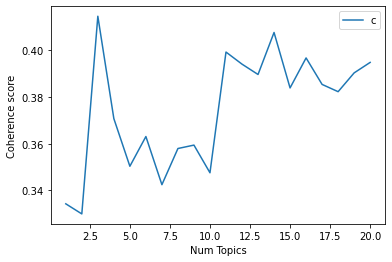

In [32]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=11, random_state=42) 
for idx, topic in model.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.036*"ac_dingin" + 0.030*"menginap" + 0.025*"sih" + 0.023*"bagus" + 0.017*"sarapan" + 0.015*"harga" + 0.015*"ac" + 0.015*"terjangkau" + 0.014*"menyenangkan" + 0.014*"lokasi_strategis"

Topic: 1 Word: 0.073*"ramah" + 0.056*"pelayanan" + 0.026*"kotor" + 0.025*"menginap" + 0.020*"parkir" + 0.019*"bau" + 0.018*"air" + 0.017*"puas" + 0.017*"tolong" + 0.016*"pelayanannya"

Topic: 2 Word: 0.042*"menginap" + 0.038*"bagus" + 0.031*"kamar_mandi" + 0.031*"pantai" + 0.031*"nyaman" + 0.021*"ramah" + 0.020*"wangi" + 0.019*"banget" + 0.019*"super" + 0.016*"air"

Topic: 3 Word: 0.059*"lokasi_strategis" + 0.031*"lokasi" + 0.025*"bagus" + 0.023*"staff_ramah" + 0.020*"tidur" + 0.019*"nyaman" + 0.018*"strategis" + 0.018*"buruk" + 0.018*"kolam_renang" + 0.017*"malam"

Topic: 4 Word: 0.033*"tenang" + 0.031*"nyaman" + 0.029*"oke" + 0.029*"sepi" + 0.025*"kebersihan" + 0.024*"bagus" + 0.023*"hotelnya" + 0.022*"suasana" + 0.020*"banget" + 0.018*"staff_ramah"

Topic: 5 Word: 0.026*"kamar_mandi" +

In [41]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus=corpus_tfidf, dictionary=model.id2word)
vis

C:\Users\Asus\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.001556  0.018585       1        1  13.425778
5     -0.015347  0.003519       2        1  10.758227
10     0.021046 -0.046916       3        1  10.059135
2     -0.044594 -0.030663       4        1   9.983007
3     -0.048342  0.013953       5        1   9.410714
9      0.069481  0.064702       6        1   9.053184
4     -0.047767  0.023199       7        1   8.918160
0     -0.088726 -0.004273       8        1   7.720520
8      0.062786 -0.118182       9        1   7.357580
6      0.056377  0.062262      10        1   7.181265
1      0.033530  0.013813      11        1   6.132430, topic_info=                 Term       Freq      Total Category  logprob  loglift
24              ramah  14.000000  14.000000  Default  30.0000  30.0000
16   lokasi_strategis  12.000000  12.000000  Default  29.0000  29.0000
39               good   9.000000   9.000000  Default  28.0000  28.0000
27        staff_ramah  11.000000  11.000000  Default  27.0000  27.0000
65               room   5.000000   5.000000  Default  26.0000  26.0000
..                ...        ...        ...      ...      ...      ...
42              harga   0.611074   9.877673  Topic11  -4.3760   0.0088
19             nyaman   0.670961  15.127053  Topic11  -4.2825  -0.3240
16   lokasi_strategis   0.620650  12.809181  Topic11  -4.3604  -0.2356
102       kamar_mandi   0.534356  12.468286  Topic11  -4.5101  -0.3583
44           kamarnya   0.474850   7.999290  Topic11  -4.6282  -0.0325

[506 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.208277         ac
0         2  0.208277         ac
0         8  0.208277         ac
0         9  0.208277         ac
1         1  0.128552  ac_dingin
...     ...       ...        ...
32        3  0.182343         yg
32        4  0.091171         yg
32        6  0.091171         yg
32        9  0.182343         yg
32       10  0.091171         yg

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 11, 3, 4, 10, 5, 1, 9, 7, 2])